
=== Linear Regression with Robust SE (HC3) ===
                            OLS Regression Results                            
Dep. Variable:         gap_of_Account   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     40.78
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.78e-33
Time:                        16:38:14   Log-Likelihood:                 520.71
No. Observations:                 363   AIC:                            -1029.
Df Residuals:                     357   BIC:                            -1006.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

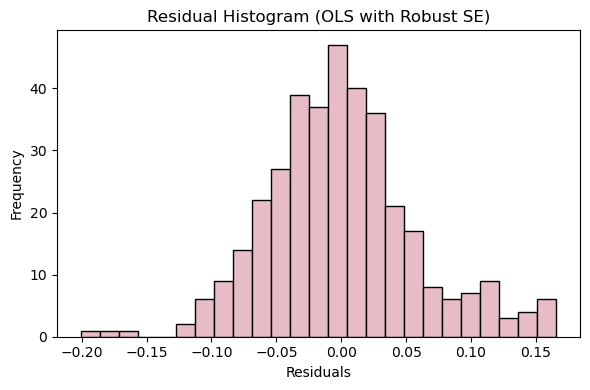

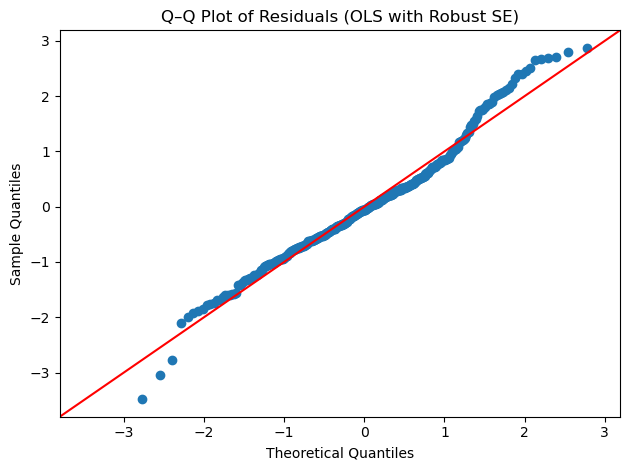

In [50]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ========= 1. Read data =========
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ========= 2. Define variables =========
y_col = "gap_of_Account"
x_vars = [
    "LFPR_Gap",
    "Women_Marriage_Rate",
    "Enroll_Female_Secondary",
    "logGDP",
    "WBL_Index"
]

# Robust column matching (case/space/underscore insensitive)
def find_col(cols, key):
    key_l = key.lower().replace("_", "").replace(" ", "")
    for c in cols:
        if key_l in c.lower().replace("_", "").replace(" ", ""):
            return c
    raise KeyError(f"Column not found: {key}")

y_col = find_col(df.columns, "gap_of_Account")
x_cols = [find_col(df.columns, x) for x in x_vars]

# ========= 3. Data cleaning & conversion =========
df_model = df[[y_col] + x_cols].copy()

def to_num(x):
    """Remove commas, %, and convert to float"""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"):
        s = s[:-1]
    try:
        return float(s)
    except:
        return np.nan

for c in [y_col] + x_cols:
    df_model[c] = df_model[c].apply(to_num)

# Drop rows with missing values
df_model = df_model.dropna()

# ========= 4. Run OLS with robust SE (HC3) =========
formula = f"{y_col} ~ {' + '.join(x_cols)}"
model = smf.ols(formula, data=df_model).fit(cov_type="HC3")

# ========= 5. Output regression summary =========
print("\n=== Linear Regression with Robust SE (HC3) ===")
print(model.summary())

# ========= 6. Create clean coefficient table =========
def star(p):
    """Add significance stars"""
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (robust SE, HC3) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4),
      "| AIC:", round(model.aic, 2),
      "| BIC:", round(model.bic, 2),
      "| N:", int(model.nobs))

# ========= 7. Residual diagnostics =========
residuals = model.resid

# --- Residual histogram ---
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (OLS with Robust SE)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Q–Q plot for normality check ---
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (OLS with Robust SE)")
plt.tight_layout()
plt.show()



=== Interaction Model (Mean-centered regressors, HC3 robust SE) ===
                            OLS Regression Results                            
Dep. Variable:         gap_of_Account   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     27.14
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           9.14e-33
Time:                        16:38:14   Log-Likelihood:                 532.27
No. Observations:                 363   AIC:                            -1047.
Df Residuals:                     354   BIC:                            -1012.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

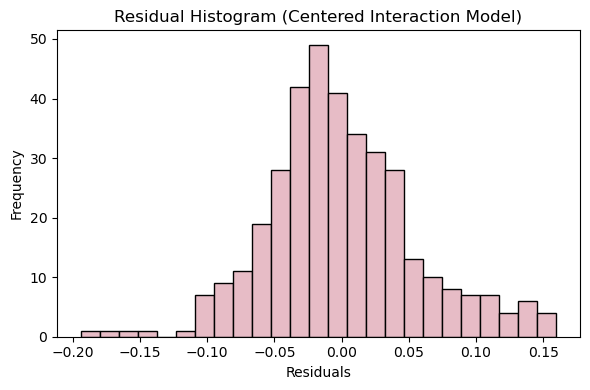

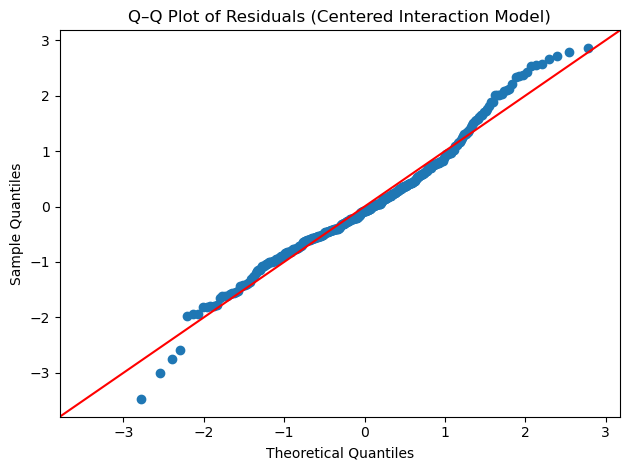

In [51]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============ 1) Read data ============
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ============ 2) Robust column finder ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

y_col   = find_col(df.columns, "gap_of_Account")
lfpr    = find_col(df.columns, "LFPR_Gap")
marry   = find_col(df.columns, "Women_Marriage_Rate")
edu     = find_col(df.columns, "Enroll_Female_Secondary")
loggdp  = find_col(df.columns, "logGDP")
wbl     = find_col(df.columns, "WBL_Index")

# ============ 3) Convert to numeric ============
def to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"): s = s[:-1]
    try: 
        return float(s)
    except:
        return np.nan

use_cols = [y_col, lfpr, marry, edu, loggdp, wbl]
dfm = df[use_cols].copy()
for c in use_cols:
    dfm[c] = dfm[c].apply(to_num)

# Drop rows with any missing among used variables
dfm = dfm.dropna().reset_index(drop=True)

# ============ 4) Mean-center continuous regressors ============
# Centering improves interpretability of main effects with interactions
for c in [lfpr, marry, edu, loggdp, wbl]:
    dfm[c + "_c"] = dfm[c] - dfm[c].mean()

# ============ 5) Build interactions on CENTERED variables ============
dfm["LFPRxWBL"] = dfm[lfpr + "_c"] * dfm[wbl + "_c"]
dfm["EDUxWBL"]  = dfm[edu  + "_c"] * dfm[wbl + "_c"]
dfm["LFPRxEDU"] = dfm[lfpr + "_c"] * dfm[edu + "_c"]

# ============ 6) Interaction OLS (centered) with HC3 robust SE ============
formula = f"""{y_col} ~ {lfpr}_c + {marry}_c + {edu}_c + {loggdp}_c + {wbl}_c
+ LFPRxWBL + EDUxWBL + LFPRxEDU
"""
model = smf.ols(formula, data=dfm).fit(cov_type="HC3")

print("\n=== Interaction Model (Mean-centered regressors, HC3 robust SE) ===")
print(model.summary())

# ============ 7) Tidy coef table with stars ============
def star(p): 
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (robust SE) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4), 
      "| AIC:", round(model.aic, 2), 
      "| BIC:", round(model.bic, 2), 
      "| N:", int(model.nobs))

# ============ 8) Residual diagnostics ============
resid = model.resid

plt.figure(figsize=(6,4))
plt.hist(resid, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (Centered Interaction Model)")
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Centered Interaction Model)")
plt.tight_layout(); plt.show()



=== Difference Model: (CreditGap - DebitGap) ===
                            OLS Regression Results                            
Dep. Variable:        GapDiff_CminusD   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     8.279
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.53e-07
Time:                        16:38:14   Log-Likelihood:                 311.23
No. Observations:                 223   AIC:                            -610.5
Df Residuals:                     217   BIC:                            -590.0
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

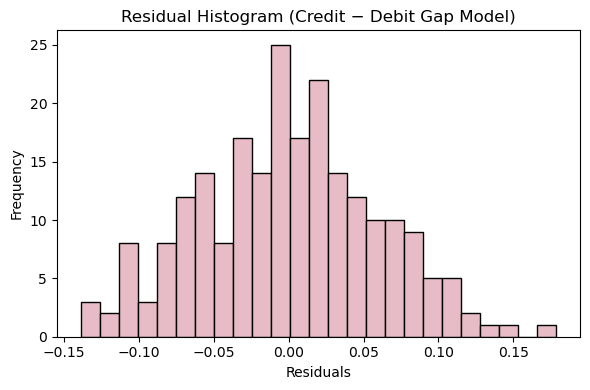

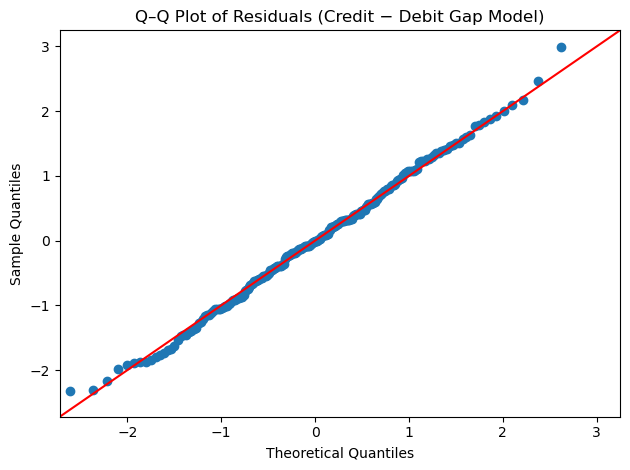

In [52]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# ============ 1) Read data ============
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ============ 2) Robust column finder ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

# ---- dependent variables ----
y_credit = find_col(df.columns, "gap_of_Credit")
y_debit  = find_col(df.columns, "gap_of_Debit")

# ---- independent variables ----
lfpr   = find_col(df.columns, "LFPR_Gap")
edu    = find_col(df.columns, "Enroll_Female_Secondary")
wbl    = find_col(df.columns, "WBL_Index")
loggdp = find_col(df.columns, "logGDP")
marry  = find_col(df.columns, "Women_Marriage_Rate")

# ============ 3) Convert to numeric ============
def to_num(x):
    """Remove commas and % then convert to float"""
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"): s = s[:-1]
    try:
        return float(s)
    except:
        return np.nan

use_cols = [y_credit, y_debit, lfpr, edu, wbl, loggdp, marry]
dfm = df[use_cols].copy()
for c in use_cols:
    dfm[c] = dfm[c].apply(to_num)

# Drop rows with any missing values
dfm = dfm.dropna().reset_index(drop=True)

# ============ 4) Construct the difference variable ============
dfm["GapDiff_CminusD"] = dfm[y_credit] - dfm[y_debit]

# ============ 5) Difference regression ============
formula = f"GapDiff_CminusD ~ {lfpr} + {edu} + {wbl} + {loggdp} + {marry}"
model = smf.ols(formula, data=dfm).fit(cov_type="HC3")

print("\n=== Difference Model: (CreditGap - DebitGap) ===")
print(model.summary())

# ============ 6) Clean coefficient table with significance stars ============
def star(p):
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (robust SE, HC3) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4),
      "| AIC:", round(model.aic, 2),
      "| BIC:", round(model.bic, 2),
      "| N:", int(model.nobs))

import matplotlib.pyplot as plt
import statsmodels.api as sm

# ===== Residual diagnostics =====
resid = model.resid

plt.figure(figsize=(6,4))
plt.hist(resid, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (Credit − Debit Gap Model)")
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Credit − Debit Gap Model)")
plt.tight_layout(); plt.show()



=== Difference Model with Interactions (Mean-centered, HC3 robust SE) ===
                            OLS Regression Results                            
Dep. Variable:        GapDiff_CminusD   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.867
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           1.57e-05
Time:                        16:38:14   Log-Likelihood:                 311.72
No. Observations:                 223   AIC:                            -605.4
Df Residuals:                     214   BIC:                            -574.8
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

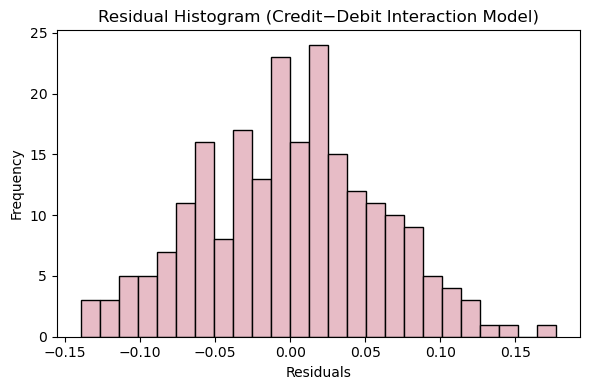

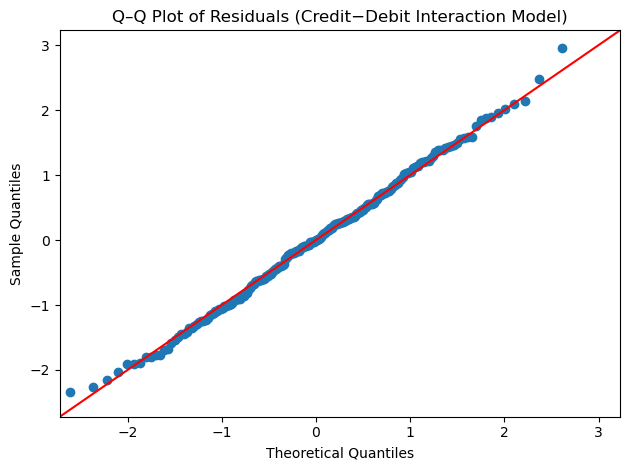

In [53]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============ 1) Read data ============
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ============ 2) Column finder (case/space insensitive) ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

# ---- dependent variables ----
y_credit = find_col(df.columns, "gap_of_Credit")
y_debit  = find_col(df.columns, "gap_of_Debit")

# ---- independent variables ----
lfpr   = find_col(df.columns, "LFPR_Gap")
edu    = find_col(df.columns, "Enroll_Female_Secondary")
wbl    = find_col(df.columns, "WBL_Index")
loggdp = find_col(df.columns, "logGDP")
marry  = find_col(df.columns, "Women_Marriage_Rate")

# ============ 3) Convert to numeric ============
def to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"): s = s[:-1]
    try: return float(s)
    except: return np.nan

use_cols = [y_credit, y_debit, lfpr, edu, wbl, loggdp, marry]
dfm = df[use_cols].copy()
for c in use_cols:
    dfm[c] = dfm[c].apply(to_num)

dfm = dfm.dropna().reset_index(drop=True)

# ============ 4) Compute Credit−Debit difference ============
dfm["GapDiff_CminusD"] = dfm[y_credit] - dfm[y_debit]

# ============ 5) Mean-center all continuous variables ============
for c in [lfpr, edu, wbl, loggdp, marry]:
    dfm[c + "_c"] = dfm[c] - dfm[c].mean()

# ============ 6) Create interaction terms ============
dfm["LFPRxWBL"] = dfm[lfpr + "_c"] * dfm[wbl + "_c"]
dfm["EDUxWBL"]  = dfm[edu  + "_c"] * dfm[wbl + "_c"]
dfm["LFPRxEDU"] = dfm[lfpr + "_c"] * dfm[edu + "_c"]

# ============ 7) Regression model ============
formula = f"""
GapDiff_CminusD ~ {lfpr}_c + {edu}_c + {wbl}_c + {loggdp}_c + {marry}_c
+ LFPRxWBL + EDUxWBL + LFPRxEDU
"""
model = smf.ols(formula, data=dfm).fit(cov_type="HC3")

print("\n=== Difference Model with Interactions (Mean-centered, HC3 robust SE) ===")
print(model.summary())

# ============ 8) Tidy coefficients table ============
def star(p): 
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (Robust SE, HC3) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4),
      "| AIC:", round(model.aic, 2),
      "| BIC:", round(model.bic, 2),
      "| N:", int(model.nobs))

# ============ 9) Residual diagnostics ============
resid = model.resid

plt.figure(figsize=(6,4))
plt.hist(resid, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (Credit−Debit Interaction Model)")
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Credit−Debit Interaction Model)")
plt.tight_layout(); plt.show()
